In [1]:
# library import
from io import open
import glob
import os
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import string
from tqdm import tqdm

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Preparing the data

In [3]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt']
Slusarski


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning names to Tensor

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
# def lineToTensor(line):
#     tensor = torch.zeros(len(line), 1, n_letters)
#     for li, letter in enumerate(line):
#         tensor[li][0][letterToIndex(letter)] = 1
#     return tensor

def lineToTensor(line):
    tensor = torch.zeros(1, len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[0][li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 5, 57])


In [6]:
print(lineToTensor('Ali').size())

torch.Size([1, 3, 57])


## Dataset Creation

In [7]:
def category_encoder(categories):
    category_dict = {category: i for i, category in enumerate(categories)}
    return category_dict

def get_category_counts(category_dict):
    category_count_dict = {category: len(category_dict[category]) for category in category_dict}
    return category_count_dict

In [8]:
category_dict = category_encoder(category_lines.keys())
print(category_dict)
category_count_dict = get_category_counts(category_lines)
print(category_count_dict)

{'Arabic': 0, 'Chinese': 1, 'French': 2, 'German': 3, 'Greek': 4, 'Czech': 5, 'Italian': 6, 'Dutch': 7, 'Korean': 8, 'English': 9, 'Portuguese': 10, 'Irish': 11, 'Scottish': 12, 'Japanese': 13, 'Vietnamese': 14, 'Polish': 15, 'Russian': 16, 'Spanish': 17}
{'Arabic': 2000, 'Chinese': 268, 'French': 277, 'German': 724, 'Greek': 203, 'Czech': 519, 'Italian': 709, 'Dutch': 297, 'Korean': 94, 'English': 3668, 'Portuguese': 74, 'Irish': 232, 'Scottish': 100, 'Japanese': 991, 'Vietnamese': 73, 'Polish': 139, 'Russian': 9408, 'Spanish': 298}


In [9]:
X = []
y = []

for category in category_lines.keys():
    for i, name in enumerate(category_lines[category]):
        name = name + ' ' * (20 - len(name))
        name = lineToTensor(name)
        X.append(name)
        y.append(torch.tensor(category_dict[category]).view(1))

X = torch.cat(X, dim=0)
y = torch.cat(y, dim=0)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: torch.Size([20074, 20, 57])
y shape: torch.Size([20074])


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [11]:
batch_size = 4
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Creating the Network

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # self.i2h = nn.Linear(input_size, hidden_size)
        # self.h2h = nn.Linear(hidden_size, hidden_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output, _ = self.rnn(input, hidden)
        output = self.h2o(output[:, -1, :])
        output = self.softmax(output)
        return output

    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn.to(device)

RNN(
  (rnn): RNN(57, 128, batch_first=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Training

In [14]:
EPOCHS = 30

### Training the network

In [15]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [16]:
def testRNN(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            hidden = model.initHidden(inputs.size(0)).to(device)
            outputs = model(inputs, hidden)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

In [17]:
def trainRNN(model, train_loader, criterion, optimizer, n_epochs=20):
    train_loss = []
    train_acc = []  
    test_loss = []
    test_acc = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for bt, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            hidden = model.initHidden(inputs.size(0)).to(device)
            outputs = model(inputs, hidden)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            
            # print(f'Epoch {epoch+1}/{n_epochs} Batch {bt+1}/{len(train_loader)} Loss: {loss.item()} Acc: {100 * correct / total}')

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        test_loss_, test_acc_ = testRNN(model, test_loader, criterion)
        test_loss.append(test_loss_)
        test_acc.append(test_acc_)

        print(f'Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss[-1]} Train Acc: {train_acc[-1]} Test Loss: {test_loss[-1]} Test Acc: {test_acc[-1]}')
    return train_loss, train_acc, test_loss, test_acc

In [18]:
train_loss, train_acc, test_loss, test_acc = trainRNN(rnn, train_loader, criterion, optimizer, EPOCHS)

100%|██████████| 4015/4015 [00:19<00:00, 206.88it/s]


Epoch 1/30 Train Loss: 1.8718023894287432 Train Acc: 46.14857712186313 Test Loss: 1.8044371996742796 Test Acc: 47.57160647571607


100%|██████████| 4015/4015 [00:19<00:00, 209.19it/s]


Epoch 2/30 Train Loss: 1.8354756493014683 Train Acc: 46.559561616539014 Test Loss: 1.8278769165633684 Test Acc: 47.57160647571607


100%|██████████| 4015/4015 [00:19<00:00, 209.53it/s]


Epoch 3/30 Train Loss: 1.8521563270840222 Train Acc: 46.42256678498038 Test Loss: 1.8407016694842582 Test Acc: 47.57160647571607


100%|██████████| 4015/4015 [00:19<00:00, 210.38it/s]


Epoch 4/30 Train Loss: 1.8575180539678073 Train Acc: 46.20462046204621 Test Loss: 1.810795684051941 Test Acc: 47.57160647571607


100%|██████████| 4015/4015 [00:19<00:00, 210.76it/s]


Epoch 5/30 Train Loss: 1.855454554110951 Train Acc: 46.24198268883492 Test Loss: 1.8775303571585165 Test Acc: 47.57160647571607


100%|██████████| 4015/4015 [00:19<00:00, 210.54it/s]


Epoch 6/30 Train Loss: 1.8554604893306719 Train Acc: 46.796189052867554 Test Loss: 1.82139725885187 Test Acc: 48.59277708592777


100%|██████████| 4015/4015 [00:19<00:00, 210.77it/s]


Epoch 7/30 Train Loss: 1.8317084567039128 Train Acc: 46.89582165763746 Test Loss: 1.849175610568419 Test Acc: 45.50435865504359


100%|██████████| 4015/4015 [00:18<00:00, 211.92it/s]


Epoch 8/30 Train Loss: 1.8655157431496183 Train Acc: 46.92072980882994 Test Loss: 1.8341740288463722 Test Acc: 47.57160647571607


100%|██████████| 4015/4015 [00:18<00:00, 211.60it/s]


Epoch 9/30 Train Loss: 1.8679737417368336 Train Acc: 46.789962015069435 Test Loss: 1.8531240158940692 Test Acc: 47.795765877957656


100%|██████████| 4015/4015 [00:19<00:00, 210.93it/s]


Epoch 10/30 Train Loss: 1.8634775507123502 Train Acc: 46.98922722460925 Test Loss: 1.8369300009244942 Test Acc: 47.447073474470734


100%|██████████| 4015/4015 [00:18<00:00, 211.70it/s]


Epoch 11/30 Train Loss: 1.8638632008103029 Train Acc: 46.88959461983934 Test Loss: 1.8522442740154457 Test Acc: 47.12328767123287


100%|██████████| 4015/4015 [00:18<00:00, 211.34it/s]


Epoch 12/30 Train Loss: 1.849282238848628 Train Acc: 46.85223239305063 Test Loss: 1.8473604002381225 Test Acc: 48.318804483188046


100%|██████████| 4015/4015 [00:19<00:00, 211.21it/s]


Epoch 13/30 Train Loss: 1.8420375259697512 Train Acc: 47.113767980571645 Test Loss: 1.8604987814013227 Test Acc: 45.952677459526775


100%|██████████| 4015/4015 [00:18<00:00, 211.99it/s]


Epoch 14/30 Train Loss: 1.8540922413430505 Train Acc: 46.403885671586025 Test Loss: 1.8628557528335734 Test Acc: 47.17310087173101


100%|██████████| 4015/4015 [00:18<00:00, 212.69it/s]


Epoch 15/30 Train Loss: 1.8252788027449236 Train Acc: 46.322934180210474 Test Loss: 1.8287253687937421 Test Acc: 41.917808219178085


100%|██████████| 4015/4015 [00:19<00:00, 211.21it/s]


Epoch 16/30 Train Loss: 1.8185277380800782 Train Acc: 46.235755651036804 Test Loss: 1.811204276444665 Test Acc: 47.19800747198008


100%|██████████| 4015/4015 [00:18<00:00, 211.46it/s]


Epoch 17/30 Train Loss: 1.8160030762032882 Train Acc: 46.93318388442618 Test Loss: 1.7992861991622058 Test Acc: 46.82440846824409


100%|██████████| 4015/4015 [00:18<00:00, 211.76it/s]


Epoch 18/30 Train Loss: 1.8205630982241328 Train Acc: 46.50351827635594 Test Loss: 1.6874984067185703 Test Acc: 47.073474470734745


100%|██████████| 4015/4015 [00:19<00:00, 209.65it/s]


Epoch 19/30 Train Loss: 1.6305733863343188 Train Acc: 50.78149324366399 Test Loss: 1.525880268778637 Test Acc: 54.99377334993773


100%|██████████| 4015/4015 [00:19<00:00, 211.23it/s]


Epoch 20/30 Train Loss: 1.5514822724775166 Train Acc: 53.61479544180833 Test Loss: 1.4902947968302436 Test Acc: 56.93648816936488


100%|██████████| 4015/4015 [00:18<00:00, 211.96it/s]


Epoch 21/30 Train Loss: 1.5210533999361255 Train Acc: 55.3334578740893 Test Loss: 1.4757842647794828 Test Acc: 58.655043586550434


100%|██████████| 4015/4015 [00:18<00:00, 211.93it/s]


Epoch 22/30 Train Loss: 1.4866263696218691 Train Acc: 57.08948253315898 Test Loss: 1.443180873887094 Test Acc: 58.804483188044834


100%|██████████| 4015/4015 [00:19<00:00, 211.08it/s]


Epoch 23/30 Train Loss: 1.4538515779782426 Train Acc: 58.889096456815494 Test Loss: 1.4078439102838358 Test Acc: 60.99626400996264


100%|██████████| 4015/4015 [00:18<00:00, 211.99it/s]


Epoch 24/30 Train Loss: 1.424250984763446 Train Acc: 59.58029765240675 Test Loss: 1.4802523066875974 Test Acc: 57.80821917808219


100%|██████████| 4015/4015 [00:18<00:00, 212.39it/s]


Epoch 25/30 Train Loss: 1.4136562853842825 Train Acc: 60.29640699919049 Test Loss: 1.399276870501365 Test Acc: 60.971357409713576


100%|██████████| 4015/4015 [00:18<00:00, 212.22it/s]


Epoch 26/30 Train Loss: 1.402120264914527 Train Acc: 60.813251136434396 Test Loss: 1.3301121593597698 Test Acc: 62.640099626400996


100%|██████████| 4015/4015 [00:18<00:00, 211.37it/s]


Epoch 27/30 Train Loss: 1.3768538581550696 Train Acc: 61.39859268945762 Test Loss: 1.3277828499045876 Test Acc: 63.8854296388543


100%|██████████| 4015/4015 [00:18<00:00, 212.11it/s]


Epoch 28/30 Train Loss: 1.3843694616985944 Train Acc: 61.36123046266891 Test Loss: 1.3586053091873123 Test Acc: 62.465753424657535


100%|██████████| 4015/4015 [00:18<00:00, 212.05it/s]


Epoch 29/30 Train Loss: 1.3845828331082568 Train Acc: 61.35500342487079 Test Loss: 1.3441094384436862 Test Acc: 64.18430884184309


100%|██████████| 4015/4015 [00:18<00:00, 211.37it/s]


Epoch 30/30 Train Loss: 1.3599179454983454 Train Acc: 62.1271561118376 Test Loss: 1.4297699978615925 Test Acc: 58.30635118306351


## Plotting the results

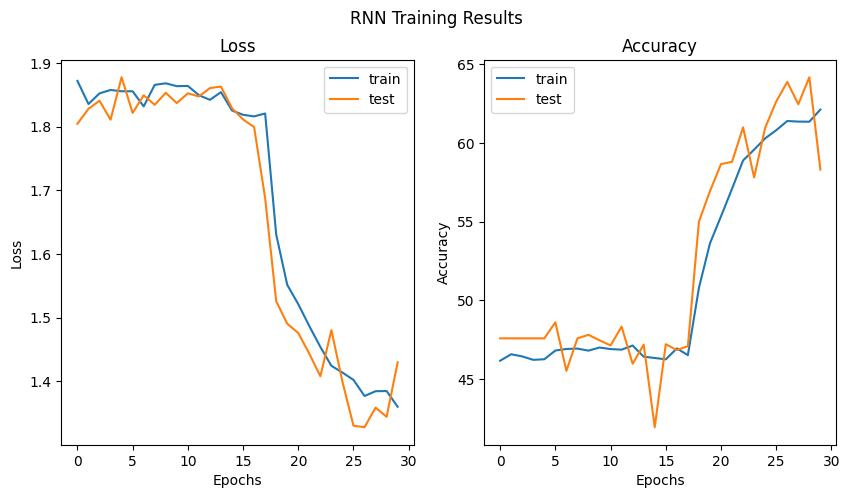

In [19]:
# plot loss, acc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# title of the plot
plt.suptitle('RNN Training Results')
plt.show()

### RNN
- Trained for 30 epochs
- Train accuracy : 62.1%
- Test accuracy  : 58.3%
- Can be trained more

# Que 2 (b)
## GRU

In [20]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # self.i2h = nn.Linear(input_size, hidden_size)
        # self.h2h = nn.Linear(hidden_size, hidden_size)
        # Gated Recurrent Unit
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output, _ = self.gru(input, hidden)
        # output = self.h2o(hidden)
        # output = self.softmax(output)
        output = self.h2o(output[:, -1, :])
        output = self.softmax(output)
        return output

    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)
gru.to(device)

GRU(
  (gru): GRU(57, 128, batch_first=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [21]:
def testGRU(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            hidden = model.initHidden(labels.size(0)).to(device)
            out = model(inputs, hidden)
            loss = criterion(out, labels)
            test_loss += loss.item()
            _, predicted = torch.max(out, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # print(f'Test Loss: {test_loss / len(test_loader)} Acc: {100 * correct / total}')
    return test_loss / len(test_loader), 100 * correct / total

In [22]:
def trainGRU(model, train_loader, criterion, optimizer, n_epochs=20):
    
    train_loss = []
    train_acc = []  
    test_loss = []
    test_acc = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for bt, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs.size())
            optimizer.zero_grad()
            hidden = model.initHidden(inputs.size(0)).to(device)
            output = model(inputs, hidden)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print(f'Epoch {epoch+1}/{n_epochs} Batch {bt+1}/{len(train_loader)} Loss: {loss.item()} Acc: {100 * correct / total}')

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        test_l, test_a = testGRU(model, test_loader, criterion)
        test_loss.append(test_l)
        test_acc.append(test_a)

        print(f'Epoch {epoch+1}/{n_epochs} Loss: {running_loss / len(train_loader)} Acc: {100 * correct / total} Test Loss: {test_l} Test Acc: {test_a}')
    return train_loss, train_acc, test_loss, test_acc

In [23]:
criterian = nn.NLLLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.001)

In [24]:
train_loss, train_acc, test_loss, test_acc = trainGRU(gru, train_loader, criterion, optimizer, n_epochs=EPOCHS)

  0%|          | 0/4015 [00:00<?, ?it/s]

100%|██████████| 4015/4015 [00:20<00:00, 196.28it/s]


Epoch 1/30 Loss: 1.389826173399567 Acc: 58.99495609938352 Test Loss: 1.060260773233817 Test Acc: 69.04109589041096


100%|██████████| 4015/4015 [00:20<00:00, 197.99it/s]


Epoch 2/30 Loss: 0.9185146049807453 Acc: 72.88125038918986 Test Loss: 0.8278364496653672 Test Acc: 75.26774595267746


100%|██████████| 4015/4015 [00:20<00:00, 197.13it/s]


Epoch 3/30 Loss: 0.7383683324511688 Acc: 77.77570209851174 Test Loss: 0.7185659819622098 Test Acc: 79.07845579078456


100%|██████████| 4015/4015 [00:20<00:00, 197.19it/s]


Epoch 4/30 Loss: 0.6348867036887893 Acc: 80.46578242729933 Test Loss: 0.6424096091878271 Test Acc: 80.0747198007472


100%|██████████| 4015/4015 [00:20<00:00, 196.21it/s]


Epoch 5/30 Loss: 0.5590047507420061 Acc: 82.45843452269756 Test Loss: 0.6187035854167174 Test Acc: 81.3200498132005


100%|██████████| 4015/4015 [00:20<00:00, 197.27it/s]


Epoch 6/30 Loss: 0.501565343452347 Acc: 84.14596176598792 Test Loss: 0.6123387611296929 Test Acc: 81.81818181818181


100%|██████████| 4015/4015 [00:20<00:00, 197.55it/s]


Epoch 7/30 Loss: 0.45057976240864517 Acc: 85.44741266579489 Test Loss: 0.6020141611938943 Test Acc: 82.11706102117061


100%|██████████| 4015/4015 [00:20<00:00, 197.06it/s]


Epoch 8/30 Loss: 0.4046632205794146 Acc: 86.82358801917928 Test Loss: 0.6045320719236893 Test Acc: 82.04234122042341


100%|██████████| 4015/4015 [00:20<00:00, 197.62it/s]


Epoch 9/30 Loss: 0.3606349576754116 Acc: 88.18108225916932 Test Loss: 0.6149464914167012 Test Acc: 81.94271481942715


100%|██████████| 4015/4015 [00:20<00:00, 198.28it/s]


Epoch 10/30 Loss: 0.32500542928927545 Acc: 89.02173236191544 Test Loss: 0.6663551349415358 Test Acc: 81.44458281444582


100%|██████████| 4015/4015 [00:20<00:00, 197.48it/s]


Epoch 11/30 Loss: 0.28646299647775714 Acc: 90.5162214334641 Test Loss: 0.6588563923424161 Test Acc: 81.5442092154421


100%|██████████| 4015/4015 [00:20<00:00, 198.06it/s]


Epoch 12/30 Loss: 0.2564359140596497 Acc: 91.06420075969861 Test Loss: 0.6989678530372292 Test Acc: 81.69364881693649


100%|██████████| 4015/4015 [00:20<00:00, 198.66it/s]


Epoch 13/30 Loss: 0.22851301210673736 Acc: 92.02939161840712 Test Loss: 0.7164746392626624 Test Acc: 81.5442092154421


100%|██████████| 4015/4015 [00:20<00:00, 199.03it/s]


Epoch 14/30 Loss: 0.2112077422947244 Acc: 92.50887352886232 Test Loss: 0.7319669071951856 Test Acc: 81.51930261519303


100%|██████████| 4015/4015 [00:20<00:00, 198.07it/s]


Epoch 15/30 Loss: 0.19264796134040368 Acc: 93.12535027087614 Test Loss: 0.7730950242329501 Test Acc: 81.49439601494396


100%|██████████| 4015/4015 [00:20<00:00, 197.19it/s]


Epoch 16/30 Loss: 0.17502555783762042 Acc: 93.86014073105424 Test Loss: 0.8439563080813628 Test Acc: 80.72229140722291


100%|██████████| 4015/4015 [00:20<00:00, 198.40it/s]


Epoch 17/30 Loss: 0.1623933560123386 Acc: 94.33962264150944 Test Loss: 0.8397650951184984 Test Acc: 80.34869240348692


100%|██████████| 4015/4015 [00:20<00:00, 198.12it/s]


Epoch 18/30 Loss: 0.15535441104682576 Acc: 94.4890715486643 Test Loss: 0.8460973947710458 Test Acc: 80.92154420921544


100%|██████████| 4015/4015 [00:20<00:00, 197.22it/s]


Epoch 19/30 Loss: 0.15038443412913297 Acc: 94.66342860701164 Test Loss: 0.8674184968615507 Test Acc: 81.02117061021171


100%|██████████| 4015/4015 [00:20<00:00, 197.72it/s]


Epoch 20/30 Loss: 0.13909246143419982 Acc: 95.02459679930257 Test Loss: 0.8670110166949782 Test Acc: 81.14570361145704


100%|██████████| 4015/4015 [00:20<00:00, 198.29it/s]


Epoch 21/30 Loss: 0.13595567359408336 Acc: 95.05573198829318 Test Loss: 0.8974185073844921 Test Acc: 81.19551681195517


100%|██████████| 4015/4015 [00:20<00:00, 198.32it/s]


Epoch 22/30 Loss: 0.13214862375110695 Acc: 95.20518089544804 Test Loss: 0.9166621255220084 Test Acc: 80.62266500622665


100%|██████████| 4015/4015 [00:20<00:00, 197.51it/s]


Epoch 23/30 Loss: 0.1294329022251603 Acc: 95.34217572700666 Test Loss: 0.908421081305908 Test Acc: 81.1706102117061


100%|██████████| 4015/4015 [00:20<00:00, 198.20it/s]


Epoch 24/30 Loss: 0.12262197823281386 Acc: 95.59748427672956 Test Loss: 0.9531422751744989 Test Acc: 80.94645080946451


100%|██████████| 4015/4015 [00:20<00:00, 198.29it/s]


Epoch 25/30 Loss: 0.12342758323106094 Acc: 95.50407870975776 Test Loss: 0.922303065283655 Test Acc: 80.74719800747198


100%|██████████| 4015/4015 [00:20<00:00, 197.57it/s]


Epoch 26/30 Loss: 0.11669840943417242 Acc: 95.62861946572016 Test Loss: 0.9636846333662152 Test Acc: 80.8717310087173


100%|██████████| 4015/4015 [00:20<00:00, 196.55it/s]


Epoch 27/30 Loss: 0.12028013531279416 Acc: 95.54144093654648 Test Loss: 0.9438036027858312 Test Acc: 81.44458281444582


100%|██████████| 4015/4015 [00:20<00:00, 198.36it/s]


Epoch 28/30 Loss: 0.11527298678924512 Acc: 95.8963820910393 Test Loss: 0.958290747974346 Test Acc: 80.67247820672478


100%|██████████| 4015/4015 [00:20<00:00, 197.59it/s]


Epoch 29/30 Loss: 0.1167640727035078 Acc: 95.62239242792204 Test Loss: 0.9613178048917318 Test Acc: 80.67247820672478


100%|██████████| 4015/4015 [00:20<00:00, 197.60it/s]


Epoch 30/30 Loss: 0.10573175844120203 Acc: 96.00846877140545 Test Loss: 0.9776431226814125 Test Acc: 80.97135740971358


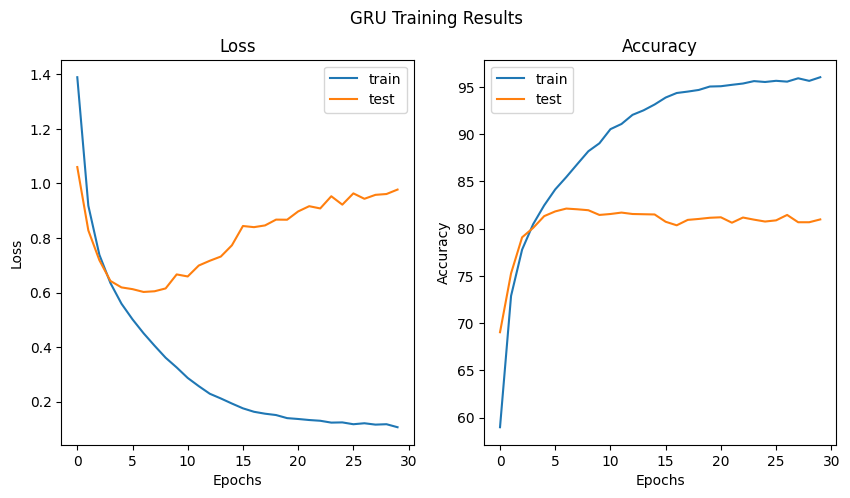

In [25]:
# plot loss, acc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# title of the plot
plt.suptitle('GRU Training Results')
plt.show()

### GRU
- Trained for 30 epochs
- Saturatino in test acurrcy after 5 epochs
- Train accuracy : 96%
- Test accuracy  : 81%

# Que 2 (c)
## LSTM

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
    
        # self.i2h = nn.Linear(input_size, hidden_size)
        # self.h2h = nn.Linear(hidden_size, hidden_size)
        # Long Short-Term Memory
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell_state):
        # hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output, _ = self.lstm(input, (hidden, cell_state))
        output = self.h2o(output[:, -1 , :])
        output = self.softmax(output)
        return output

    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
lstm.to(device)

LSTM(
  (lstm): LSTM(57, 128, batch_first=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [27]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

In [28]:
def testLSTM(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    for bt, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        hidden = model.initHidden(inputs.size(0)).to(device)
        cell_state = model.initHidden(inputs.size(0)).to(device)
        output = model(inputs, hidden, cell_state)
        loss = criterion(output, labels)
        test_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return test_loss / len(test_loader), 100 * correct / total

In [29]:
def trainLSTM(model, train_loader, criterion, optimizer, n_epochs=20):
    train_loss = []
    train_acc = []  
    test_loss = []
    test_acc = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for bt, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            hidden = model.initHidden(inputs.size(0)).to(device)
            cell_state = model.initHidden(inputs.size(0)).to(device)
            output = model(inputs, hidden, cell_state)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print(f'Epoch {epoch+1}/{n_epochs} Batch {bt+1}/{len(train_loader)} Loss: {loss.item()} Acc: {100 * correct / total}')
    
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        e_test_loss, e_test_acc = testLSTM(model, test_loader, criterion)
        test_loss.append(e_test_loss)
        test_acc.append(e_test_acc)

        print(f'Epoch {epoch+1}/{n_epochs} Loss: {running_loss / len(train_loader)} Acc: {100 * correct / total} Test Loss: {e_test_loss} Test Acc: {e_test_acc}')
    return train_loss, train_acc, test_loss, test_acc

In [30]:
train_loss, train_acc, test_loss, test_acc = trainLSTM(lstm, train_loader, criterion, optimizer, n_epochs=EPOCHS)

  0%|          | 0/4015 [00:00<?, ?it/s]

100%|██████████| 4015/4015 [00:21<00:00, 187.03it/s]


Epoch 1/30 Loss: 1.7830425922305393 Acc: 48.45880814496544 Test Loss: 1.4874003120137758 Test Acc: 54.52054794520548


100%|██████████| 4015/4015 [00:21<00:00, 188.22it/s]


Epoch 2/30 Loss: 1.3810469377593393 Acc: 60.57662370010586 Test Loss: 1.2425747758141195 Test Acc: 65.0560398505604


100%|██████████| 4015/4015 [00:21<00:00, 188.58it/s]


Epoch 3/30 Loss: 1.1629924309326876 Acc: 67.87471199950184 Test Loss: 1.0878955954286933 Test Acc: 69.14072229140723


100%|██████████| 4015/4015 [00:21<00:00, 188.40it/s]


Epoch 4/30 Loss: 0.9538014978281736 Acc: 72.9248396537767 Test Loss: 0.8861975096690466 Test Acc: 75.093399750934


100%|██████████| 4015/4015 [00:21<00:00, 187.64it/s]


Epoch 5/30 Loss: 0.8087390729998456 Acc: 76.78560308861074 Test Loss: 0.8026321695238492 Test Acc: 76.4881693648817


100%|██████████| 4015/4015 [00:21<00:00, 188.53it/s]


Epoch 6/30 Loss: 0.715053190259026 Acc: 78.64126035245035 Test Loss: 0.791864967766307 Test Acc: 76.43835616438356


100%|██████████| 4015/4015 [00:21<00:00, 187.84it/s]


Epoch 7/30 Loss: 0.6481735488601017 Acc: 80.34124167133695 Test Loss: 0.6974272705116468 Test Acc: 79.47696139476962


100%|██████████| 4015/4015 [00:21<00:00, 188.17it/s]


Epoch 8/30 Loss: 0.5921895523108762 Acc: 81.63646553334578 Test Loss: 0.6634980996062646 Test Acc: 80.82191780821918


100%|██████████| 4015/4015 [00:21<00:00, 187.71it/s]


Epoch 9/30 Loss: 0.5386310172322132 Acc: 83.36758204122299 Test Loss: 0.6586213733047683 Test Acc: 80.52303860523038


100%|██████████| 4015/4015 [00:21<00:00, 188.52it/s]


Epoch 10/30 Loss: 0.4901306951670885 Acc: 84.22068621956535 Test Loss: 0.6467019966882194 Test Acc: 81.1706102117061


100%|██████████| 4015/4015 [00:21<00:00, 188.34it/s]


Epoch 11/30 Loss: 0.4519270456152675 Acc: 85.69649417771966 Test Loss: 0.6229730663119833 Test Acc: 81.51930261519303


100%|██████████| 4015/4015 [00:21<00:00, 188.20it/s]


Epoch 12/30 Loss: 0.4100565867280211 Acc: 86.860950245968 Test Loss: 0.6552347864529281 Test Acc: 81.04607721046077


100%|██████████| 4015/4015 [00:21<00:00, 187.46it/s]


Epoch 13/30 Loss: 0.3778180624718915 Acc: 87.98804408742761 Test Loss: 0.6580697322760418 Test Acc: 81.1706102117061


100%|██████████| 4015/4015 [00:21<00:00, 188.06it/s]


Epoch 14/30 Loss: 0.34567479118088223 Acc: 88.69169935861511 Test Loss: 0.6328068874735856 Test Acc: 82.66500622665006


100%|██████████| 4015/4015 [00:21<00:00, 188.25it/s]


Epoch 15/30 Loss: 0.3231051799460284 Acc: 89.45139796998568 Test Loss: 0.6586318373688028 Test Acc: 81.64383561643835


100%|██████████| 4015/4015 [00:21<00:00, 187.89it/s]


Epoch 16/30 Loss: 0.2928891614386419 Acc: 90.26713992153933 Test Loss: 0.6780282356444087 Test Acc: 82.04234122042341


100%|██████████| 4015/4015 [00:21<00:00, 188.64it/s]


Epoch 17/30 Loss: 0.2690309429427606 Acc: 91.21364966685348 Test Loss: 0.7113553480515387 Test Acc: 81.46948941469489


100%|██████████| 4015/4015 [00:21<00:00, 187.87it/s]


Epoch 18/30 Loss: 0.2520117390623494 Acc: 91.68067750171244 Test Loss: 0.6815961920021538 Test Acc: 82.39103362391033


100%|██████████| 4015/4015 [00:21<00:00, 188.78it/s]


Epoch 19/30 Loss: 0.233904588954009 Acc: 92.30960831932249 Test Loss: 0.7859794983354469 Test Acc: 81.5442092154421


100%|██████████| 4015/4015 [00:21<00:00, 187.76it/s]


Epoch 20/30 Loss: 0.21418045242062955 Acc: 92.65832243601719 Test Loss: 0.7607560862753583 Test Acc: 81.36986301369863


100%|██████████| 4015/4015 [00:21<00:00, 188.29it/s]


Epoch 21/30 Loss: 0.20053665629033304 Acc: 93.44292919858023 Test Loss: 0.7869329006902969 Test Acc: 81.27023661270236


100%|██████████| 4015/4015 [00:21<00:00, 188.32it/s]


Epoch 22/30 Loss: 0.18625304278837204 Acc: 93.71069182389937 Test Loss: 0.8427445755180567 Test Acc: 80.47322540473225


100%|██████████| 4015/4015 [00:21<00:00, 187.76it/s]


Epoch 23/30 Loss: 0.17576431380286062 Acc: 94.14658446976773 Test Loss: 0.8302438531036681 Test Acc: 81.22042341220424


100%|██████████| 4015/4015 [00:21<00:00, 186.84it/s]


Epoch 24/30 Loss: 0.1718782344928356 Acc: 94.10922224297902 Test Loss: 0.8090136737115998 Test Acc: 81.02117061021171


100%|██████████| 4015/4015 [00:21<00:00, 188.23it/s]


Epoch 25/30 Loss: 0.16269460837691857 Acc: 94.43925524627934 Test Loss: 0.847895044033736 Test Acc: 81.3200498132005


100%|██████████| 4015/4015 [00:21<00:00, 188.04it/s]


Epoch 26/30 Loss: 0.15167267568443363 Acc: 94.81287751416652 Test Loss: 0.8392765897837657 Test Acc: 80.12453300124533


100%|██████████| 4015/4015 [00:21<00:00, 187.64it/s]


Epoch 27/30 Loss: 0.1436304316319197 Acc: 94.86269381655147 Test Loss: 0.8962051586574158 Test Acc: 80.82191780821918


100%|██████████| 4015/4015 [00:21<00:00, 187.78it/s]


Epoch 28/30 Loss: 0.13660409375991203 Acc: 95.3546298026029 Test Loss: 0.8902897256525211 Test Acc: 81.04607721046077


100%|██████████| 4015/4015 [00:21<00:00, 187.82it/s]


Epoch 29/30 Loss: 0.13447483331127885 Acc: 95.32972165141042 Test Loss: 0.9018745848871219 Test Acc: 80.99626400996264


100%|██████████| 4015/4015 [00:21<00:00, 187.81it/s]


Epoch 30/30 Loss: 0.13375117634506736 Acc: 95.25499719783299 Test Loss: 0.9180197370352525 Test Acc: 80.92154420921544


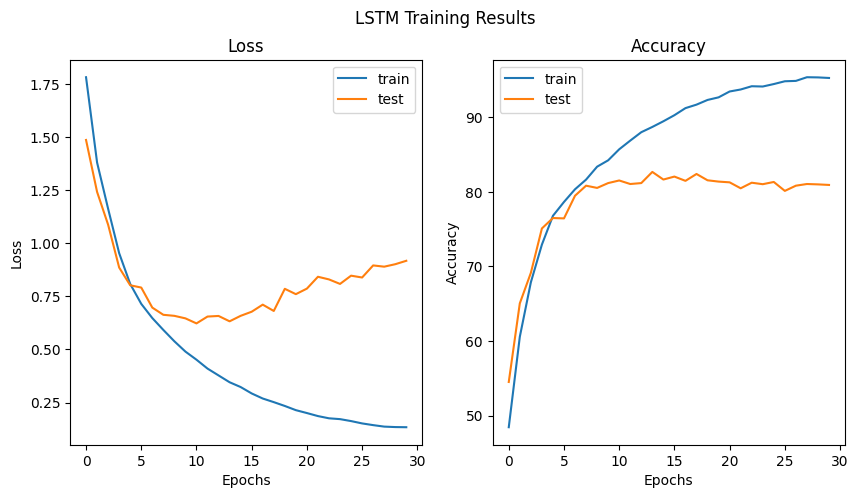

In [31]:
# plot loss, acc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# title of the plot
plt.suptitle('LSTM Training Results')
plt.show()

### LSTM
- Trained for 30 epochs
- Saturatino in test acurrcy after 10 epochs
- Train accuracy : 95%
- Test accuracy  : 81%

### Comparision between RNN, GRU, LSTM
- Training all models for 30 epochs with same initial learning rate of 0.001
- Train Accuracy : RNN (62.1%) < GRU (96 %) ~= LSTM (95%)
- Test Accuracy  : RNN (58.3%) < GRU (81 %) ~= LSTM (81%)